In [1]:
!pip install nltk scikit-learn
!pip install imbalanced-learn
!pip install contractions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import pickle
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
import nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 6.5 MB/s eta 0:00:00


In [10]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

os.makedirs('data/processed', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)


df = pd.read_csv("/content/sample_data/mental_health.csv")
total_rows = df.shape[0]

print(f"Total number of rows in the dataset: {total_rows}")
print(df.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Total number of rows in the dataset: 53043
   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety


In [11]:
import re
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

nltk.download("stopwords")
nltk.download("wordnet")

tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

negations = {'not', 'no', 'nor', 'won', 'don', 'shouldn', 'couldn', 'wouldn', 'aren', 'isn', 'doesn', 'haven', 'hadn', 'hasn', 'mightn'}
keep_words = {'i', 'me', 'my', 'myself', 'mine'}
custom_stopwords = set(stopwords.words('english')) - negations - keep_words


def preprocess_text(text):

    text = contractions.fix(text)

    text = text.lower()

    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    text = re.sub(r'<.*?>', '', text)

    text = re.sub(r"[^a-zA-Z0-9\s\.,!?']", '', text)

    text = re.sub(r'\s+', ' ', text).strip()

    tokens = tokenizer.tokenize(text)

    tokens = [word for word in tokens if word not in custom_stopwords]

    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

print("\nPreprocessing text data...")

df['processed_text'] = df['statement'].astype(str).apply(preprocess_text)

print("\nExamples of processed text:")
for i in range(5):
    print(f"Original: {df['statement'].iloc[i]}")
    print(f"Processed: {df['processed_text'].iloc[i]}")
    print()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Preprocessing text data...

Examples of processed text:
Original: oh my gosh
Processed: oh my gosh

Original: trouble sleeping, confused mind, restless heart. All out of tune
Processed: trouble sleeping confused mind restless heart tune

Original: All wrong, back off dear, forward doubt. Stay in a restless and restless place
Processed: wrong back dear forward doubt stay restless restless place

Original: I've shifted my focus to something else but I'm still worried
Processed: i shifted my focus something else i still worried

Original: I'm restless and restless, it's been a month now, boy. What do you mean?
Processed: i restless restless month boy mean



In [12]:
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['processed_text'])
y = df['status']

In [15]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder

ros = RandomOverSampler(random_state=42)
X_balanced, y_balanced = ros.fit_resample(X_tfidf, y)


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_balanced)

from collections import Counter

# Count the encoded labels
encoded_counts = Counter(y_encoded)

# Create a dictionary with class names as keys
named_counts = {
    label_encoder.inverse_transform([k])[0]: v
    for k, v in encoded_counts.items()
}

print("Balanced class counts with class names:", named_counts)


Balanced class counts with class names: {'Anxiety': 16351, 'Normal': 16351, 'Depression': 16351, 'Suicidal': 16351, 'Stress': 16351, 'Bipolar': 16351, 'Personality disorder': 16351}


In [17]:
from sklearn.model_selection import train_test_split

print("\nSplitting balanced data into train, validation, and test sets...")

X_train, X_temp, y_train, y_temp = train_test_split(
    X_balanced, y_encoded,
    test_size=0.4,
    random_state=42,
    stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print(f"Train set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")



Splitting balanced data into train, validation, and test sets...
Train set size: 68674
Validation set size: 22891
Test set size: 22892


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC


models = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'SVC with rbf kernel': SVC(kernel='rbf', random_state=42, gamma='scale', C=1),
    'Logistic Regression': LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=500),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1)
}


results = {}

print("\n Training and evaluating models...\n")

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)


    report = classification_report(y_val, y_val_pred, target_names=label_encoder.classes_, output_dict=True)
    results[name] = {
        'model': model,
        'accuracy': accuracy_score(y_val, y_val_pred),
        'report': report
    }


    print(f"\n{name} - Validation Accuracy: {results[name]['accuracy']:.4f}")
    print(classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))
    print('-' * 80)



🔍 Training and evaluating models...

Training Multinomial Naive Bayes...

Multinomial Naive Bayes - Validation Accuracy: 0.7025
                      precision    recall  f1-score   support

             Anxiety       0.73      0.78      0.76      3270
             Bipolar       0.80      0.77      0.78      3270
          Depression       0.58      0.51      0.54      3270
              Normal       0.83      0.58      0.68      3271
Personality disorder       0.73      0.88      0.80      3270
              Stress       0.70      0.65      0.67      3270
            Suicidal       0.59      0.75      0.66      3270

            accuracy                           0.70     22891
           macro avg       0.71      0.70      0.70     22891
        weighted avg       0.71      0.70      0.70     22891

--------------------------------------------------------------------------------
Training SVC with rbf kernel...


In [ ]:

model_names = list(results.keys())
accuracies = [results[m]['accuracy'] for m in model_names]

plt.figure(figsize=(10, 5))
plt.bar(model_names, accuracies)
plt.title("Validation Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=15)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_model_name]['model']

print(f"\n Best model based on validation: {best_model_name}")


y_test_pred = best_model.predict(X_test)

print(f"\n🧪 {best_model_name} - Test Set Performance:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))



🧪 Evaluating models on the Test Set...

Multinomial Naive Bayes - Test Accuracy: 0.6981
                      precision    recall  f1-score   support

             Anxiety       0.73      0.78      0.76      3270
             Bipolar       0.80      0.77      0.78      3270
          Depression       0.57      0.49      0.53      3270
              Normal       0.81      0.57      0.67      3270
Personality disorder       0.70      0.88      0.78      3271
              Stress       0.72      0.64      0.68      3270
            Suicidal       0.60      0.75      0.67      3271

            accuracy                           0.70     22892
           macro avg       0.70      0.70      0.69     22892
        weighted avg       0.70      0.70      0.69     22892

--------------------------------------------------------------------------------
Linear SVM - Test Accuracy: 0.8470
                      precision    recall  f1-score   support

             Anxiety       0.92      0.92      

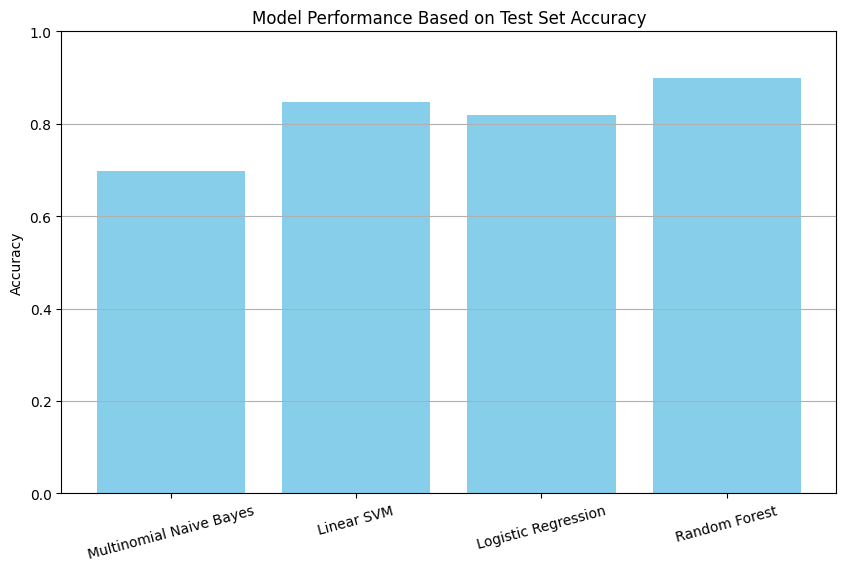

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt


test_results = {}

print("\n Evaluating models on the Test Set...\n")

for name, model_info in results.items():
    model = model_info['model']

    y_test_pred = model.predict(X_test)

    test_accuracy = accuracy_score(y_test, y_test_pred)


    test_results[name] = test_accuracy


    print(f"{name} - Test Accuracy: {test_accuracy:.4f}")
    print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))
    print('-' * 80)


plt.figure(figsize=(10, 6))
model_names = list(test_results.keys())
test_accuracies = list(test_results.values())

plt.bar(model_names, test_accuracies, color='skyblue')
plt.title('Model Performance Based on Test Set Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()



✅ Testing the best model: Random Forest

📋 Classification Report (Test Set):
                      precision    recall  f1-score   support

             Anxiety       0.95      0.97      0.96      3270
             Bipolar       0.97      0.96      0.97      3270
          Depression       0.81      0.67      0.73      3270
              Normal       0.88      0.92      0.90      3270
Personality disorder       0.92      1.00      0.96      3271
              Stress       0.97      0.96      0.96      3270
            Suicidal       0.77      0.80      0.79      3271

            accuracy                           0.90     22892
           macro avg       0.90      0.90      0.90     22892
        weighted avg       0.90      0.90      0.90     22892



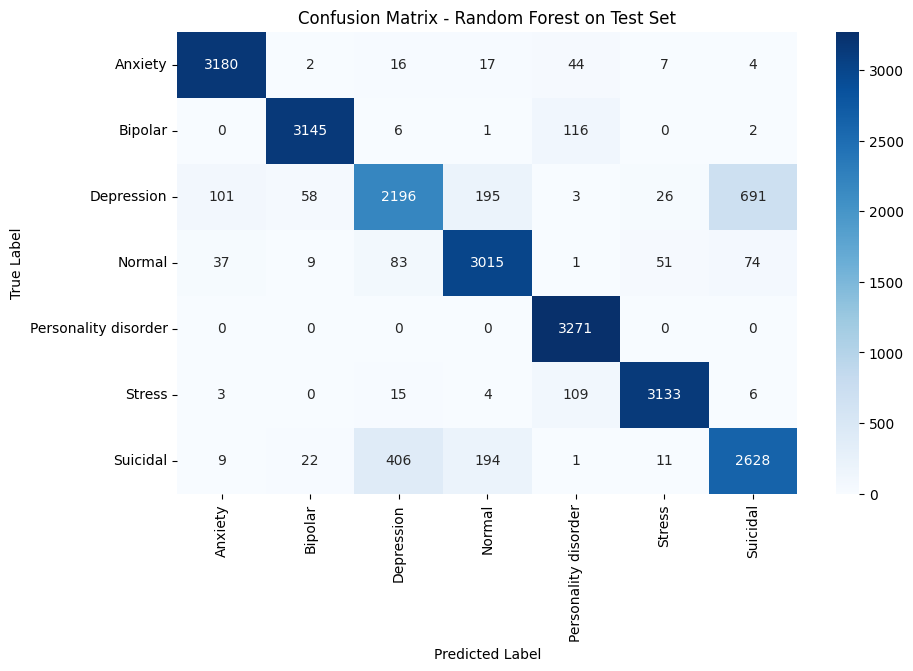

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


print(f"\n Testing the best model: {best_model_name}")


y_test_pred = best_model.predict(X_test)


print("\n Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title(f"Confusion Matrix - {best_model_name} on Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
def predict_mental_health(texts):
    """
    Predicts the mental health status of given texts using the best trained model.

    Args:
        texts (str or list): A single string or a list of text strings.

    Returns:
        List of predictions (decoded class labels)
    """
    if isinstance(texts, str):
        texts = [texts]


    processed = [preprocess_text(text) for text in texts]


    tfidf_vectors = tfidf.transform(processed)

    predictions = best_model.predict(tfidf_vectors)


    return label_encoder.inverse_transform(predictions)


In [ ]:

print(predict_mental_health("I'm so worried about my exam"))